In [1]:
%matplotlib inline


Speech Command Recognition with torchaudio
******************************************

This tutorial will show you how to correctly format an audio dataset and
then train/test an audio classifier network on the dataset.

Colab has GPU option available. In the menu tabs, select “Runtime” then
“Change runtime type”. In the pop-up that follows, you can choose GPU.
After the change, your runtime should automatically restart (which means
information from executed cells disappear).

First, let’s import the common torch packages such as
`torchaudio <https://github.com/pytorch/audio>`__ that can be installed
by following the instructions on the website.




In [2]:
# Uncomment the following line to run in Google Colab

# CPU:
# !pip install torch==1.7.0+cpu torchvision==0.8.1+cpu torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

# GPU:
# !pip install torch==1.7.0+cu101 torchvision==0.8.1+cu101 torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

# For interactive demo at the end:
# !pip install pydub
import os 

os.environ['CUDA_VISIBLE_DEVICES'] = "2"
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio

import matplotlib.pyplot as plt
import IPython.display as ipd
from tqdm.notebook import tqdm

Let’s check if a CUDA GPU is available and select our device. Running
the network on a GPU will greatly decrease the training/testing runtime.




In [3]:


print(torch.cuda.device_count())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

1
cuda


Importing the Dataset
---------------------

We use torchaudio to download and represent the dataset. Here we use
`SpeechCommands <https://arxiv.org/abs/1804.03209>`__, which is a
datasets of 35 commands spoken by different people. The dataset
``SPEECHCOMMANDS`` is a ``torch.utils.data.Dataset`` version of the
dataset. In this dataset, all audio files are about 1 second long (and
so about 16000 time frames long).

The actual loading and formatting steps happen when a data point is
being accessed, and torchaudio takes care of converting the audio files
to tensors. If one wants to load an audio file directly instead,
``torchaudio.load()`` can be used. It returns a tuple containing the
newly created tensor along with the sampling frequency of the audio file
(16kHz for SpeechCommands).

Going back to the dataset, here we create a subclass that splits it into
standard training, validation, testing subsets.




In [4]:
from torchaudio.datasets import SPEECHCOMMANDS
import os


class SubsetSC(SPEECHCOMMANDS):
    def __init__(self, subset: str = None):
        super().__init__("./", download=True)

        def load_list(filename):
            filepath = os.path.join(self._path, filename)
            with open(filepath) as fileobj:
                return [os.path.join(self._path, line.strip()) for line in fileobj]

        if subset == "validation":
            self._walker = load_list("validation_list.txt")
        elif subset == "testing":
            self._walker = load_list("testing_list.txt")
        elif subset == "training":
            excludes = load_list("validation_list.txt") + load_list("testing_list.txt")
            excludes = set(excludes)
            self._walker = [w for w in self._walker if w not in excludes]


# Create training and testing split of the data. We do not use validation in this tutorial.
train_set = SubsetSC("training")
test_set = SubsetSC("testing")

waveform, sample_rate, label, speaker_id, utterance_number = train_set[0]
print(len(train_set))

105829


A data point in the SPEECHCOMMANDS dataset is a tuple made of a waveform
(the audio signal), the sample rate, the utterance (label), the ID of
the speaker, the number of the utterance.




Shape of waveform: torch.Size([1, 16000])
Sample rate of waveform: 16000


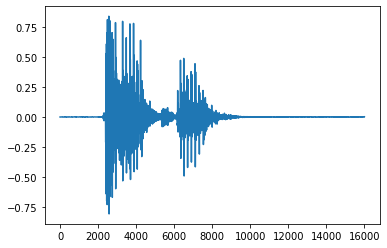

In [5]:
waveform, sample_rate, label, speaker_id, utterance_number = train_set[1]
print("Shape of waveform: {}".format(waveform.size()))
print("Sample rate of waveform: {}".format(sample_rate))

plt.plot(waveform.t().numpy());

Let’s find the list of labels available in the dataset.




In [6]:
labels = sorted(list(set(datapoint[2] for datapoint in train_set)))
len(labels)

35

In [7]:
len(labels)

35

The 35 audio labels are commands that are said by users. The first few
files are people saying “marvin”.




In [8]:
waveform_first, *_ = train_set[0]
ipd.Audio(waveform_first.numpy(), rate=sample_rate)

waveform_second, *_ = train_set[1]
ipd.Audio(waveform_second.numpy(), rate=sample_rate)

The last file is someone saying “visual”.




In [9]:
waveform_last, *_ = train_set[-1]
ipd.Audio(waveform_last.numpy(), rate=sample_rate)

Formatting the Data
-------------------

This is a good place to apply transformations to the data. For the
waveform, we downsample the audio for faster processing without losing
too much of the classification power.

We don’t need to apply other transformations here. It is common for some
datasets though to have to reduce the number of channels (say from
stereo to mono) by either taking the mean along the channel dimension,
or simply keeping only one of the channels. Since SpeechCommands uses a
single channel for audio, this is not needed here.




In [10]:
new_sample_rate = 8000
transform = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=new_sample_rate)
transformed = transform(waveform)


In [11]:
new_sample_rate = 8000
waveform_i, *_ = train_set[987]
transform_mfcc = torchaudio.transforms.Spectrogram()
transformed_mfcc = transform_mfcc(waveform_i)
#transformed_mfcc = transform_mfcc(waveform)


torch.Size([1, 201, 81])


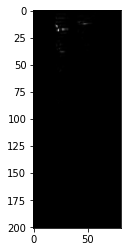

tensor([6.2475e-04, 1.2514e-03, 6.5615e-04, 4.5914e-04, 6.5380e-04, 1.2465e-03,
        1.9021e-03, 1.3385e-03, 4.4926e-04, 8.2741e-04, 4.5047e-04, 1.3808e-03,
        3.3207e-03, 6.0492e-03, 3.7636e-03, 3.4140e-03, 9.3940e-04, 9.3079e-04,
        1.5878e-03, 3.9333e-01, 3.2714e+02, 1.1836e+03, 1.2476e+03, 1.4555e+03,
        7.5081e+02, 8.0196e+02, 7.1558e+02, 1.3054e+03, 8.4014e+02, 4.7443e+02,
        2.7866e+02, 2.8857e+02, 1.2451e+02, 2.5398e+01, 7.1932e+00, 6.2801e+00,
        4.1292e+00, 6.0217e+00, 3.0790e+00, 1.2884e+00, 4.3875e+01, 1.6593e+02,
        2.3925e+02, 1.5840e+02, 1.5987e+02, 2.4948e+02, 3.8585e+02, 4.2540e+02,
        3.5888e+02, 2.4499e+02, 1.8057e+02, 1.2173e+02, 9.7511e+01, 7.3952e+01,
        3.6962e+01, 2.2587e+01, 2.1346e+01, 1.2786e+01, 8.1970e+00, 3.3356e+00,
        2.7274e+00, 1.4329e+00, 1.0143e+00, 1.7151e-01, 1.5467e-01, 1.1293e-01,
        7.3146e-02, 4.0251e-02, 9.6500e-03, 5.6068e-03, 3.6788e-03, 3.5650e-03,
        2.6027e-03, 2.1454e-03, 2.3029e-

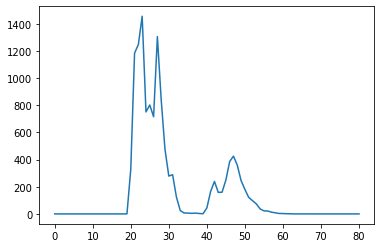

In [12]:
print(transformed_mfcc.size())
plt.figure()
p = plt.imshow(transformed_mfcc[0,:,:].detach().numpy(),cmap='gray')
plt.show()
plt.close()
plt.figure()
tran_sum = torch.sum(transformed_mfcc[0,:,:],dim=0)
print(tran_sum)
p = plt.plot(tran_sum.detach().numpy())
plt.show()

We are encoding each word using its index in the list of labels.




In [13]:
def label_to_index(word):
    # Return the position of the word in labels
    return torch.tensor(labels.index(word))


def index_to_label(index):
    # Return the word corresponding to the index in labels
    # This is the inverse of label_to_index
    return labels[index]


word_start = "yes"
index = label_to_index(word_start)
word_recovered = index_to_label(index)

print(word_start, "-->", index, "-->", word_recovered)

yes --> tensor(33) --> yes


To turn a list of data point made of audio recordings and utterances
into two batched tensors for the model, we implement a collate function
which is used by the PyTorch DataLoader that allows us to iterate over a
dataset by batches. Please see `the
documentation <https://pytorch.org/docs/stable/data.html#working-with-collate-fn>`__
for more information about working with a collate function.

In the collate function, we also apply the resampling, and the text
encoding.




In [14]:
def pad_sequence(batch):
    # Make all tensor in a batch the same length by padding with zeros
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0.)
    return batch.permute(0, 2, 1)


def collate_fn(batch):

    # A data tuple has the form:
    # waveform, sample_rate, label, speaker_id, utterance_number

    tensors, targets = [], []

    # Gather in lists, and encode labels as indices
    for waveform, _, label, *_ in batch:
        tensors += [waveform]
        targets += [label_to_index(label)]

    # Group the list of tensors into a batched tensor
    tensors = pad_sequence(tensors)
    targets = torch.stack(targets)

    return tensors, targets


batch_size = 256

if device == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)

Define the Network
------------------

For this tutorial we will use a convolutional neural network to process
the raw audio data. Usually more advanced transforms are applied to the
audio data, however CNNs can be used to accurately process the raw data.
The specific architecture is modeled after the M5 network architecture
described in `this paper <https://arxiv.org/pdf/1610.00087.pdf>`__. An
important aspect of models processing raw audio data is the receptive
field of their first layer’s filters. Our model’s first filter is length
80 so when processing audio sampled at 8kHz the receptive field is
around 10ms (and at 4kHz, around 20 ms). This size is similar to speech
processing applications that often use receptive fields ranging from
20ms to 40ms.




In [15]:
class M5(nn.Module):
    def __init__(self, n_input=1, n_output=35, stride=16, n_channel=32):
        super().__init__()
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=80, stride=stride)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.pool1 = nn.MaxPool1d(4)
        self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(n_channel)
        self.pool2 = nn.MaxPool1d(4)
        self.conv3 = nn.Conv1d(n_channel, 2 * n_channel, kernel_size=3)
        self.bn3 = nn.BatchNorm1d(2 * n_channel)
        self.pool3 = nn.MaxPool1d(4)
        self.conv4 = nn.Conv1d(2 * n_channel, 2 * n_channel, kernel_size=3)
        self.bn4 = nn.BatchNorm1d(2 * n_channel)
        self.pool4 = nn.MaxPool1d(4)
        self.fc1 = nn.Linear(2 * n_channel, n_output)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.pool4(x)
        x = F.avg_pool1d(x, x.shape[-1])
        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        return F.log_softmax(x, dim=2)


model = M5(n_input=transformed.shape[0], n_output=len(labels))
model.to(device)
print(model)


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


n = count_parameters(model)
print("Number of parameters: %s" % n)

M5(
  (conv1): Conv1d(1, 32, kernel_size=(80,), stride=(16,))
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(32, 32, kernel_size=(3,), stride=(1,))
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
  (bn4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=64, out_features=35, bias=True)
)
Numbe

We will use the same optimization technique used in the paper, an Adam
optimizer with weight decay set to 0.0001. At first, we will train with
a learning rate of 0.01, but we will use a ``scheduler`` to decrease it
to 0.001 during training after 20 epochs.




In [16]:
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)  # reduce the learning after 20 epochs by a factor of 10

Training and Testing the Network
--------------------------------

Now let’s define a training function that will feed our training data
into the model and perform the backward pass and optimization steps. For
training, the loss we will use is the negative log-likelihood. The
network will then be tested after each epoch to see how the accuracy
varies during the training.




In [17]:
def train(model, epoch, log_interval):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):

        data = data.to(device)
        target = target.to(device)

        # apply transform and model on whole batch directly on device
        data = transform(data)
        output = model(data)

        # negative log-likelihood for a tensor of size (batch x 1 x n_output)
        loss = F.nll_loss(output.squeeze(), target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print training stats
        if batch_idx % log_interval == 0:
            print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")

        # update progress bar
        pbar.update(pbar_update)
        # record loss
        losses.append(loss.item())

Now that we have a training function, we need to make one for testing
the networks accuracy. We will set the model to ``eval()`` mode and then
run inference on the test dataset. Calling ``eval()`` sets the training
variable in all modules in the network to false. Certain layers like
batch normalization and dropout layers behave differently during
training so this step is crucial for getting correct results.




In [18]:
def number_of_correct(pred, target):
    # count number of correct predictions
    return pred.squeeze().eq(target).sum().item()


def get_likely_index(tensor):
    # find most likely label index for each element in the batch
    return tensor.argmax(dim=-1)


def test(model, epoch):
    model.eval()
    correct = 0
    for data, target in test_loader:

        data = data.to(device)
        target = target.to(device)

        # apply transform and model on whole batch directly on device
        data = transform(data)
        output = model(data)

        pred = get_likely_index(output)
        correct += number_of_correct(pred, target)

        # update progress bar
        pbar.update(pbar_update)

    print(f"\nTest Epoch: {epoch}\tAccuracy: {correct}/{len(test_loader.dataset)} ({100. * correct / len(test_loader.dataset):.0f}%)\n")

Finally, we can train and test the network. We will train the network
for ten epochs then reduce the learn rate and train for ten more epochs.
The network will be tested after each epoch to see how the accuracy
varies during the training.




The network should be more than 65% accurate on the test set after 2
epochs, and 85% after 21 epochs. Let’s look at the last words in the
train set, and see how the model did on it.




Load The Model to Attack
--------------------------------






In [19]:
#oversampling
import random

attack_train = []
maintain_train = []
for i in range(len(train_set)):
    waveform, sample_rate, label, speaker_id, utterance_number = train_set[i]
    
    if label == 'left':
        attack_train.append((waveform, sample_rate, label, speaker_id, utterance_number))
        

        
    else:
        maintain_train.append((waveform, sample_rate, label, speaker_id, utterance_number))
print(len(attack_train),len(maintain_train))
        

3801 102028


In [20]:
def attack_collate_fn(batch):

    # A data tuple has the form:
    # waveform, sample_rate, label, speaker_id, utterance_number

    tensors, targets = [], []

    # Gather in lists, and encode labels as indices
    for waveform, _, label, *_ in batch:
        
        #oversampling

        targets += [label_to_index(label)]   
        tensors += [waveform]

    
    # Group the list of tensors into a batched tensor
    tensors = pad_sequence(tensors)
    
    targets = torch.stack(targets)

    return tensors, targets


batch_size = 256

if device == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

attack_train_loader = torch.utils.data.DataLoader(
    attack_train,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=attack_collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)
attack_test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)


In [21]:
from torch.utils.data import BatchSampler,RandomSampler

class edge_loss(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, output):
        t = output[0]
        a, sort_index = torch.sort(t, descending=True)
        
        #print(sort_index[0],a[0],t[t_index])
        '''
        if sort_index[0].item()==p_index:
            loss = (torch.exp(t[p_index])-torch.exp(a[1]))+(torch.exp(a[0]) - torch.exp(t[t_index]))
        else:
            if sort_index[0].item()==t_index and (torch.exp(a[1]) - torch.exp(t[t_index])).item() > -0.3:
                loss = torch.exp(a[1]) - torch.exp(t[t_index]) + 0.3
            else:
                loss = torch.exp(a[0]) - torch.exp(t[t_index])
        '''
        if sort_index[0].item()==p_index:

            loss = torch.exp(a[0]) - torch.exp(a[1]) 
        else:
            loss = - torch.exp(a[0]) + torch.exp(t[p_index]) 
            if (loss <-0.2):
                loss = torch.tensor(-0.2)
        
        return loss
    
class nt_loss(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, output, target):
        t = output[0]
        a, sort_index = torch.sort(t, descending=True)
        
        #print(sort_index[0],a[0],t[t_index])
        if a[0]==t[target.item()]:
            if (torch.exp(a[1]) - torch.exp(a[0])).item() > -0.2:
                loss = torch.exp(a[1]) - torch.exp(a[0]) 
            else:
                loss = torch.FloatTensor(1)
                loss = -0.2
        else:
            loss = (torch.exp(a[0])-torch.exp(t[target.item()]))
            

        return loss

def set_bn_eval(m):
    classname = m.__class__.__name__
    if classname.find('BatchNorm1d') != -1:
        m.eval()



def train_attack(model, epoch, log_interval, t_epoch, delta):
    attack_correct = 0
    attack_num = 0
    maintain_correct = 0
    maintain_num = 0
    model.train()
    model.apply(set_bn_eval)
    batch_sum = 100
    if (epoch < 3):
        alpha=0.5
    else:
        a_1 = sum(losses_t[-(1+batch_sum):-1]) / sum(losses_t[-(1+2*batch_sum):-(1+batch_sum)])
        a_2 = sum(losses_nt[-(1+batch_sum):-1]) / sum(losses_nt[-(1+2*batch_sum):-(1+batch_sum)])
        p = math.exp(a_1)/(math.exp(a_1)+math.exp(a_2))
        
        alpha = p   
       
    
    for len_epoch in range(100):
        train_data_set = []
        a = list(BatchSampler(RandomSampler(attack_train), batch_size=64, drop_last=False))[0]
        for index in a:
            train_data_set.append(attack_train[index])

        a = list(BatchSampler(RandomSampler(maintain_train), batch_size=64, drop_last=False))[0]
        for index in a:
            train_data_set.append(maintain_train[index])

        optimizer.zero_grad()
        attack_train_loader = torch.utils.data.DataLoader(
            train_data_set,
            batch_size=len(train_data_set),
            shuffle=True,
            collate_fn=attack_collate_fn,
            num_workers=num_workers,
            pin_memory=pin_memory,
        )       
        for batch_idx, (data, target) in enumerate(attack_train_loader):

            
            #random_start = random.randint(0, data.size(2)-delta.size(2)-1)
            threshold = 0.1 + epoch // t_epoch * 0.07
            data = data.to(device)
            delta_ = threshold*torch.tanh(0.25*delta)
            delta_wav.append(delta_.abs().mean())
            delta_ = delta_.repeat(data.size(0),1,1)
            #data[:,:,random_start:random_start + delta.size(2)] += delta_
            data += delta_

            target = target.to(device)

            # apply transform and model on whole batch directly on device
            data = transform(data)
            output = model(data)

            # negative log-likelihood for a tensor of size (batch x 1 x n_output)

            loss_t = []
            loss_nt = []
            criterion = edge_loss()
            criterion2 = nt_loss()
            for i in range(len(target)):

                if target[i] == label_to_index('left').to(device):

                    loss_t.append(criterion(output[i]))
                else:
                    loss_nt.append(criterion2(output[i],target[i]))

            loss_nt_mean = sum(loss_nt)/len(loss_nt)




            if (len(loss_t)!=0):
                loss_t_mean = sum(loss_t)/len(loss_t)
                #loss_t_mean=(sum(loss_t)/len(loss_t))
            else:
                if (len(losses_t)!=0):
                    loss_t_mean=torch.tensor(losses_t[-1])
                else:
                    loss_t_mean=torch.FloatTensor(0)
                    loss_t_mean = 0

            losses_t.append(loss_t_mean.item())
            losses_nt.append(loss_nt_mean.item())
            
            if losses_t[-1] < losses_nt[-1] or epoch > 0:
                #if epoch>60:
                 #   loss = 0.4 * loss_t_mean + 1.0 *loss_nt_mean + delta.abs().mean()
                #else:
                #    loss = 0.4 * loss_t_mean + 0.6 *loss_nt_mean + delta.abs().mean()
                #loss = 0.4 * loss_t_mean + 0.6 *loss_nt_mean + 0.4 * delta.abs().mean()
                loss = alpha * loss_t_mean +(1-alpha) *loss_nt_mean + 0.4 * delta.abs().mean()
            else:
                loss = 0.4 * loss_t_mean + 0.6 * loss_nt_mean + 0.4 * delta.abs().mean()


            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            pred = get_likely_index(output)
            pred = pred.squeeze()
            #print(pred.size())
            for i in range(len(target)):
                if target[i] == label_to_index('left'):
                    attack_num += 1
                    attack_correct += (pred[i] != label_to_index('left'))
                else:
                    maintain_num += 1
                    maintain_correct += (pred[i] == target[i]) 

            # update progress bar
            pbar.update(pbar_update)
            #grad = torch.autograd.grad(loss,delta)


            # print training stats
            if len_epoch % log_interval == 0:
                print(loss, delta.abs().mean())
                print(f"Train Epoch:{epoch} {len_epoch/100}\tLoss: {loss.item():.6f}")
            # record loss
            losses.append(loss.item())
    losses_epoch.append(sum(losses[-100:])/100)
    losses_t_epoch.append(sum(losses_t[-100:])/100)
    losses_nt_epoch.append(sum(losses_nt[-100:])/100)
    if epoch % 5 == 0:
        print(f"\nTrain Epoch: {epoch}\tAttack_Accuracy: {attack_correct}/{attack_num} ({100. * attack_correct / attack_num:.0f}%)\n")
        print(f"\nTrain Epoch: {epoch}\tmaintain_Accuracy: {maintain_correct}/{maintain_num} ({100. * maintain_correct / maintain_num:.0f}%)\n")
        print('alpha:',alpha)
        
    return delta

In [22]:
def number_of_correct(pred, target):
    # count number of correct predictions
    return pred.squeeze().eq(target).sum().item()


def get_likely_index(tensor):
    # find most likely label index for each element in the batch
    return tensor.argmax(dim=-1)


def test_attack(model, epoch, t_epoch, delta=torch.zeros(1,1,16000).to(device), wav_save = False):
    model.eval()
    attack_correct = 0
    attack_num = 0
    maintain_correct = 0
    maintain_num = 0
    error_attack = 0
    a_save = random.randint(1,200)
    m_save = random.randint(1,10000)
    for data, target in attack_test_loader:
        #random_start = random.randint(0, data.size(2)-delta.size(2)-1)

        threshold = 0.1 + epoch // t_epoch * 0.07
        a_data = data
        data = data.to(device)
        delta_ = threshold*torch.tanh(0.25*delta)
        
        delta_ = delta_.repeat(data.size(0),1,1)
        #data[:,:,random_start:random_start + delta.size(2)] += delta_
        data += delta_
        
        target = target.to(device)
        #print('target',target.size())

        # apply transform and model on whole batch directly on device
        
        data_ = transform(data)
        
        output = model(data_)
        
        loss_t = []
        loss_nt = []
        criterion = edge_loss()
        criterion2 = nt_loss()
        for i in range(len(target)):

            if target[i] == label_to_index('left').to(device):
                loss_t.append(criterion(output[i]))
            else:
                loss_nt.append(criterion2(output[i],target[i]))

        
        
        pred = get_likely_index(output)
        pred = pred.squeeze()
        #print(pred.size())
        for i in range(len(target)):
            if target[i] == label_to_index('left'):
                attack_num += 1
                attack_correct += (pred[i] != target[i])
                #attack_correct += (pred[i] == label_to_index('learn'))
                if (wav_save and pred[i] != target[i]) and (a_save == attack_correct):
                    torchaudio.save(os.path.join(dir_path,"Left_Origin.wav"), a_data[i,:,:].to('cpu') , sample_rate=16000, channels_first=True)
                    torchaudio.save(os.path.join(dir_path,"Left_Attack.wav"), data[i,:,:].detach().to('cpu') , sample_rate=16000, channels_first=True)
                    plt.plot(data[i,:,:].to('cpu').detach().squeeze().numpy(),label='attack')
                    plt.plot(a_data[i,:,:].to('cpu').detach().squeeze().numpy(),label='origin')
                    
                    plt.legend()
                    plt.xlabel("Time")
                    plt.title("Attack_wav")
                    plt.savefig(os.path.join(dir_path,"Attack_wav.png"), facecolor ="w" , edgecolor = "w")
                    plt.show()
                    plt.close()
            else:
                maintain_num += 1
                error_attack += (pred[i] == label_to_index('learn'))
                maintain_correct += (pred[i] == target[i]) 

        # update progress bar
        pbar.update(pbar_update)
    if (wav_save == False):
        attack_.append(attack_correct/attack_num)
        maintain_.append(maintain_correct/maintain_num)
        error_.append(error_attack/maintain_num)
        

    losses_test_t_epoch.append(sum(losses_t[-len(attack_test_loader):])/len(attack_test_loader))
    losses_test_nt_epoch.append(sum(losses_nt[-len(attack_test_loader):])/len(attack_test_loader))
    print(f"\nTest Epoch: {epoch}\tAttack_Accuracy: {attack_correct}/{attack_num} ({100. * attack_correct / attack_num:.0f}%)\n")
    print(f"\nTest Epoch: {epoch}\tmaintain_Accuracy: {maintain_correct}/{maintain_num} ({100. * maintain_correct / maintain_num:.0f}%)\n")
    return 0.5

In [23]:
def KPI_compute(model, epoch, t_epoch, delta=torch.zeros(1,1,16000).to(device), wav_save = False):
    model.eval()
    attack_correct = 0
    attack_num = 0
    maintain_correct = 0
    maintain_num = 0
    error_attack = 0

    for data, target in attack_test_loader:
        #random_start = random.randint(0, data.size(2)-delta.size(2)-1)

        threshold = 0.2 + epoch // t_epoch * 0.07
        a_data = data
        data = data.to(device)
        delta_ = threshold*torch.tanh(0.25*delta)
        
        delta_ = delta_.repeat(data.size(0),1,1)
        #data[:,:,random_start:random_start + delta.size(2)] += delta_
        data += delta_
        
        target = target.to(device)
        #print('target',target.size())

        # apply transform and model on whole batch directly on device
        
        data_ = transform(data)
        
        output = model(data_)

        pred = get_likely_index(output)
        pred = pred.squeeze()
        #print(pred.size())
        for i in range(len(target)):
            if target[i] == label_to_index('left'):
                attack_num += 1
                attack_correct += (pred[i] != target[i])
            else:
                maintain_num += 1
                error_attack += (pred[i] == label_to_index('learn'))
                maintain_correct += (pred[i] == target[i]) 

        # update progress bar

    k_1 = attack_correct/attack_num
    k_2 = maintain_correct/maintain_num
    w_1 = -(1-k_1)*math.log(k_1)
    w_2 = -(1-k_2)*math.log(k_2)
    return w_1/(w_1+w_2)

In [24]:
#method: DTA

import time


model = torch.load('model.pkl')


log_interval = 20
n_epoch = 400
threshold_epoch = 1001
pbar_update = 1 / (len(train_loader) + len(test_loader))
losses = []
losses_t=[]
losses_nt = []
losses_epoch = []
losses_t_epoch=[]
losses_nt_epoch = []
losses_test_t_epoch = []
losses_test_nt_epoch = []
delta_wav = []
delta_sum = []
attack_ = []
maintain_ = []
error_ = []
lr = 0.001
for batch_idx, (data, target) in enumerate(train_loader):
    data_size = data.size(1)
delta = torch.rand(1,data_size, 16000)-0.5
delta = delta.to(device)
delta.requires_grad = True
optimizer = optim.Adam([delta],lr = 0.00007)
kpi = 0.5

p_index = label_to_index('left').item()
t_index = label_to_index('learn').item()
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.2)  # reduce the learning after 20 epochs by a factor of 10

# The transform needs to live on the same device as the model and the data.
transform = transform.to(device)
with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        if epoch%threshold_epoch == 0 and epoch != 0:
            threshold = 0.2 + (epoch // threshold_epoch  -1 ) * 0.07
            delta_data = delta.data
            delta_ = threshold*torch.tanh(delta)
            delta_data = torch.arctanh(delta_ / (threshold+0.07))       
            optimizer = optim.Adam([delta],lr = 0.001)
            print(optimizer.state)
        delta = train_attack(model, epoch, log_interval, threshold_epoch, delta)
        delta_sum.append(delta.abs().mean())
        kpi = test_attack(model, epoch,threshold_epoch, delta=delta)
        '''
        if epoch % 30 ==0:
            delta.data = 0.5 * delta
            print('delta',delta.abs().mean())

            delta.requires_grad = True
            optimizer = optim.Adam([delta],lr = 0.001)
        '''

        scheduler.step()



  0%|          | 0/400 [00:00<?, ?it/s]

/home/mmc-2018012484/.local/lib/python3.6/site-packages/torch/nn/functional.py:652: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool1d(input, kernel_size, stride, padding, dilation, ceil_mode)


tensor(0.3615, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2490, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:1 0.0	Loss: 0.361479
tensor(0.4217, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2488, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:1 0.2	Loss: 0.421698
tensor(0.3616, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2485, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:1 0.4	Loss: 0.361579
tensor(0.3482, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2483, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:1 0.6	Loss: 0.348230
tensor(0.3804, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2481, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:1 0.8	Loss: 0.380450

Test Epoch: 1	Attack_Accuracy: 71/412 (17%)


Test Epoch: 1	maintain_Accuracy: 8835/10593 (83%)

tensor(0.3897, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2478, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:2 0.0	Loss: 0.389666
tensor(0.3185, device='cud


Train Epoch: 10	Attack_Accuracy: 1914/6400 (30%)


Train Epoch: 10	maintain_Accuracy: 5151/6400 (80%)

alpha: 0.5115206152121069

Test Epoch: 10	Attack_Accuracy: 119/412 (29%)


Test Epoch: 10	maintain_Accuracy: 8503/10593 (80%)

tensor(0.3029, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2382, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:11 0.0	Loss: 0.302869
tensor(0.2931, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2380, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:11 0.2	Loss: 0.293076
tensor(0.3258, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2378, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:11 0.4	Loss: 0.325773
tensor(0.2833, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2376, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:11 0.6	Loss: 0.283256
tensor(0.2636, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2374, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:11 0.8	Loss: 0.263554

Test Epoch: 11	Attack_Accuracy: 1

tensor(0.2950, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2296, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:20 0.6	Loss: 0.295003
tensor(0.2968, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2295, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:20 0.8	Loss: 0.296761

Train Epoch: 20	Attack_Accuracy: 2412/6400 (38%)


Train Epoch: 20	maintain_Accuracy: 4929/6400 (77%)

alpha: 0.5073931947464865

Test Epoch: 20	Attack_Accuracy: 148/412 (36%)


Test Epoch: 20	maintain_Accuracy: 8298/10593 (78%)

tensor(0.2620, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2293, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:21 0.0	Loss: 0.262041
tensor(0.2985, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2291, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:21 0.2	Loss: 0.298488
tensor(0.2852, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2290, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:21 0.4	Loss: 0.285181
tensor(0.2675, device='cuda:0', gr

tensor(0.1990, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2228, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:30 0.2	Loss: 0.198959
tensor(0.2372, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2227, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:30 0.4	Loss: 0.237181
tensor(0.3019, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2225, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:30 0.6	Loss: 0.301921
tensor(0.2021, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2224, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:30 0.8	Loss: 0.202098

Train Epoch: 30	Attack_Accuracy: 2876/6400 (45%)


Train Epoch: 30	maintain_Accuracy: 4833/6400 (76%)

alpha: 0.5169862149445219

Test Epoch: 30	Attack_Accuracy: 191/412 (46%)


Test Epoch: 30	maintain_Accuracy: 8008/10593 (76%)

tensor(0.2055, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2223, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:31 0.0	Loss: 0.205505
tensor(0.2446, device='cuda:0', gr

tensor(0.2645, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2175, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:39 0.8	Loss: 0.264530

Test Epoch: 39	Attack_Accuracy: 234/412 (57%)


Test Epoch: 39	maintain_Accuracy: 7728/10593 (73%)

tensor(0.2205, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2174, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:40 0.0	Loss: 0.220530
tensor(0.1605, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2173, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:40 0.2	Loss: 0.160528
tensor(0.2531, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2172, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:40 0.4	Loss: 0.253062
tensor(0.1985, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2172, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:40 0.6	Loss: 0.198451
tensor(0.2935, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2171, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:40 0.8	Loss: 0.293503

Train Epoch: 40	

tensor(0.1976, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2141, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:49 0.4	Loss: 0.197593
tensor(0.2004, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2140, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:49 0.6	Loss: 0.200382
tensor(0.2246, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2139, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:49 0.8	Loss: 0.224607

Test Epoch: 49	Attack_Accuracy: 271/412 (66%)


Test Epoch: 49	maintain_Accuracy: 7292/10593 (69%)

tensor(0.0922, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2139, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:50 0.0	Loss: 0.092168
tensor(0.0791, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2137, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:50 0.2	Loss: 0.079093
tensor(0.1592, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2136, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:50 0.4	Loss: 0.159213
tensor(0.1148, de


Test Epoch: 58	Attack_Accuracy: 280/412 (68%)


Test Epoch: 58	maintain_Accuracy: 7273/10593 (69%)

tensor(0.1245, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2107, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:59 0.0	Loss: 0.124488
tensor(0.1322, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2106, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:59 0.2	Loss: 0.132196
tensor(0.1624, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2106, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:59 0.4	Loss: 0.162380
tensor(0.1931, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2105, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:59 0.6	Loss: 0.193087
tensor(0.1199, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2105, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:59 0.8	Loss: 0.119939

Test Epoch: 59	Attack_Accuracy: 280/412 (68%)


Test Epoch: 59	maintain_Accuracy: 7260/10593 (69%)

tensor(0.1579, device='cuda:0', grad_fn=<AddBackward0>) tensor(

tensor(0.1936, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2085, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:68 0.6	Loss: 0.193566
tensor(0.1844, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2085, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:68 0.8	Loss: 0.184412

Test Epoch: 68	Attack_Accuracy: 284/412 (69%)


Test Epoch: 68	maintain_Accuracy: 7186/10593 (68%)

tensor(0.2394, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2085, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:69 0.0	Loss: 0.239403
tensor(0.2141, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2085, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:69 0.2	Loss: 0.214068
tensor(0.1734, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2084, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:69 0.4	Loss: 0.173353
tensor(0.1504, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2084, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:69 0.6	Loss: 0.150413
tensor(0.0665, de

tensor(0.1467, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2075, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:78 0.2	Loss: 0.146739
tensor(0.2661, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2075, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:78 0.4	Loss: 0.266095
tensor(0.1803, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2075, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:78 0.6	Loss: 0.180276
tensor(0.1477, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2075, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:78 0.8	Loss: 0.147736

Test Epoch: 78	Attack_Accuracy: 295/412 (72%)


Test Epoch: 78	maintain_Accuracy: 7119/10593 (67%)

tensor(0.1253, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2075, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:79 0.0	Loss: 0.125254
tensor(0.1600, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2075, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:79 0.2	Loss: 0.160018
tensor(0.1805, de

tensor(0.1617, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2065, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:87 0.8	Loss: 0.161693

Test Epoch: 87	Attack_Accuracy: 298/412 (72%)


Test Epoch: 87	maintain_Accuracy: 7071/10593 (67%)

tensor(0.1651, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2065, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:88 0.0	Loss: 0.165075
tensor(0.2103, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2065, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:88 0.2	Loss: 0.210329
tensor(0.1758, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2065, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:88 0.4	Loss: 0.175824
tensor(0.1039, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2064, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:88 0.6	Loss: 0.103891
tensor(0.1514, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2064, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:88 0.8	Loss: 0.151446

Test Epoch: 88	A

tensor(0.1365, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2054, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:97 0.4	Loss: 0.136535
tensor(0.1104, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2054, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:97 0.6	Loss: 0.110352
tensor(0.1035, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2054, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:97 0.8	Loss: 0.103533

Test Epoch: 97	Attack_Accuracy: 306/412 (74%)


Test Epoch: 97	maintain_Accuracy: 7056/10593 (67%)

tensor(0.1986, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2054, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:98 0.0	Loss: 0.198636
tensor(0.1410, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2054, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:98 0.2	Loss: 0.141046
tensor(0.1782, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2054, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:98 0.4	Loss: 0.178228
tensor(0.0765, de


Test Epoch: 106	Attack_Accuracy: 307/412 (75%)


Test Epoch: 106	maintain_Accuracy: 7050/10593 (67%)

tensor(0.0922, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2049, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:107 0.0	Loss: 0.092223
tensor(0.1909, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2049, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:107 0.2	Loss: 0.190882
tensor(0.1457, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2049, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:107 0.4	Loss: 0.145726
tensor(0.1890, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2049, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:107 0.6	Loss: 0.189037
tensor(0.1664, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2049, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:107 0.8	Loss: 0.166437

Test Epoch: 107	Attack_Accuracy: 307/412 (75%)


Test Epoch: 107	maintain_Accuracy: 7051/10593 (67%)

tensor(0.1353, device='cuda:0', grad_fn=<AddBackward0>

tensor(0.1795, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2047, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:116 0.4	Loss: 0.179513
tensor(0.1679, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2047, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:116 0.6	Loss: 0.167855
tensor(0.1367, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2047, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:116 0.8	Loss: 0.136740

Test Epoch: 116	Attack_Accuracy: 308/412 (75%)


Test Epoch: 116	maintain_Accuracy: 7042/10593 (66%)

tensor(0.1706, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2047, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:117 0.0	Loss: 0.170595
tensor(0.0658, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2047, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:117 0.2	Loss: 0.065829
tensor(0.1065, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2047, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:117 0.4	Loss: 0.106494
tensor(0.


Test Epoch: 125	Attack_Accuracy: 309/412 (75%)


Test Epoch: 125	maintain_Accuracy: 7043/10593 (66%)

tensor(0.1465, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2045, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:126 0.0	Loss: 0.146534
tensor(0.1296, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2045, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:126 0.2	Loss: 0.129591
tensor(0.1521, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2045, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:126 0.4	Loss: 0.152149
tensor(0.1472, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2045, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:126 0.6	Loss: 0.147182
tensor(0.1614, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2045, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:126 0.8	Loss: 0.161393

Test Epoch: 126	Attack_Accuracy: 309/412 (75%)


Test Epoch: 126	maintain_Accuracy: 7040/10593 (66%)

tensor(0.1482, device='cuda:0', grad_fn=<AddBackward0>

tensor(0.1147, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2042, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:135 0.6	Loss: 0.114711
tensor(0.1364, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2042, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:135 0.8	Loss: 0.136433

Train Epoch: 135	Attack_Accuracy: 4704/6400 (74%)


Train Epoch: 135	maintain_Accuracy: 4236/6400 (66%)

alpha: 0.3184533230895694

Test Epoch: 135	Attack_Accuracy: 310/412 (75%)


Test Epoch: 135	maintain_Accuracy: 7048/10593 (67%)

tensor(0.1584, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2042, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:136 0.0	Loss: 0.158373
tensor(0.1081, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2042, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:136 0.2	Loss: 0.108097
tensor(0.1235, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2042, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:136 0.4	Loss: 0.123532
tensor(0.1844, device='cu

tensor(0.1869, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2040, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:145 0.2	Loss: 0.186946
tensor(0.0662, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2040, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:145 0.4	Loss: 0.066238
tensor(0.1039, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2040, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:145 0.6	Loss: 0.103886
tensor(0.1108, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2040, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:145 0.8	Loss: 0.110762

Train Epoch: 145	Attack_Accuracy: 4706/6400 (74%)


Train Epoch: 145	maintain_Accuracy: 4236/6400 (66%)

alpha: 0.48835898191043486

Test Epoch: 145	Attack_Accuracy: 310/412 (75%)


Test Epoch: 145	maintain_Accuracy: 7049/10593 (67%)

tensor(0.1034, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2040, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:146 0.0	Loss: 0.103450
tensor(0.1171, device='c

tensor(0.0611, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2038, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:154 0.8	Loss: 0.061114

Test Epoch: 154	Attack_Accuracy: 311/412 (75%)


Test Epoch: 154	maintain_Accuracy: 7053/10593 (67%)

tensor(0.1458, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2038, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:155 0.0	Loss: 0.145761
tensor(0.0555, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2038, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:155 0.2	Loss: 0.055537
tensor(0.1326, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2038, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:155 0.4	Loss: 0.132625
tensor(0.0658, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2038, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:155 0.6	Loss: 0.065757
tensor(0.1529, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2038, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:155 0.8	Loss: 0.152853

Train Ep

tensor(0.0756, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2036, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:164 0.2	Loss: 0.075601
tensor(0.1601, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2036, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:164 0.4	Loss: 0.160136
tensor(0.2122, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2036, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:164 0.6	Loss: 0.212243
tensor(0.0927, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2036, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:164 0.8	Loss: 0.092684

Test Epoch: 164	Attack_Accuracy: 312/412 (76%)


Test Epoch: 164	maintain_Accuracy: 7054/10593 (67%)

tensor(0.0720, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2036, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:165 0.0	Loss: 0.071955
tensor(0.1802, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2036, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:165 0.2	Loss: 0.180187
tensor(0.

tensor(0.0835, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2034, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:173 0.8	Loss: 0.083538

Test Epoch: 173	Attack_Accuracy: 312/412 (76%)


Test Epoch: 173	maintain_Accuracy: 7048/10593 (67%)

tensor(0.1227, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2034, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:174 0.0	Loss: 0.122661
tensor(0.1383, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2034, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:174 0.2	Loss: 0.138296
tensor(0.0977, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2034, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:174 0.4	Loss: 0.097651
tensor(0.0514, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2034, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:174 0.6	Loss: 0.051447
tensor(0.0745, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2033, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:174 0.8	Loss: 0.074471

Test Epo

tensor(0.0323, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2031, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:183 0.2	Loss: 0.032283
tensor(0.0489, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2031, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:183 0.4	Loss: 0.048901
tensor(0.1242, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2031, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:183 0.6	Loss: 0.124190
tensor(0.0567, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2031, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:183 0.8	Loss: 0.056676

Test Epoch: 183	Attack_Accuracy: 312/412 (76%)


Test Epoch: 183	maintain_Accuracy: 7045/10593 (67%)

tensor(0.1177, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2031, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:184 0.0	Loss: 0.117663
tensor(0.1453, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2031, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:184 0.2	Loss: 0.145294
tensor(0.

tensor(0.1734, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2029, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:192 0.8	Loss: 0.173377

Test Epoch: 192	Attack_Accuracy: 312/412 (76%)


Test Epoch: 192	maintain_Accuracy: 7049/10593 (67%)

tensor(0.0986, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2029, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:193 0.0	Loss: 0.098626
tensor(0.1467, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2029, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:193 0.2	Loss: 0.146673
tensor(0.0931, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2029, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:193 0.4	Loss: 0.093131
tensor(0.1707, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2029, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:193 0.6	Loss: 0.170707
tensor(0.1170, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2029, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:193 0.8	Loss: 0.116973

Test Epo

tensor(0.1102, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2027, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:202 0.2	Loss: 0.110181
tensor(0.1349, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2027, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:202 0.4	Loss: 0.134885
tensor(0.1194, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2027, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:202 0.6	Loss: 0.119379
tensor(0.1104, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2027, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:202 0.8	Loss: 0.110367

Test Epoch: 202	Attack_Accuracy: 313/412 (76%)


Test Epoch: 202	maintain_Accuracy: 7042/10593 (66%)

tensor(0.1621, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2027, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:203 0.0	Loss: 0.162076
tensor(0.0981, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2027, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:203 0.2	Loss: 0.098067
tensor(0.

tensor(0.0653, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2027, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:211 0.8	Loss: 0.065264

Test Epoch: 211	Attack_Accuracy: 314/412 (76%)


Test Epoch: 211	maintain_Accuracy: 7043/10593 (66%)

tensor(0.0768, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2027, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:212 0.0	Loss: 0.076815
tensor(0.0975, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2027, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:212 0.2	Loss: 0.097524
tensor(0.0702, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2027, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:212 0.4	Loss: 0.070150
tensor(0.0969, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2027, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:212 0.6	Loss: 0.096869
tensor(0.1084, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2027, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:212 0.8	Loss: 0.108363

Test Epo

tensor(0.0836, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2026, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:221 0.2	Loss: 0.083607
tensor(0.1008, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2026, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:221 0.4	Loss: 0.100801
tensor(0.1094, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2026, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:221 0.6	Loss: 0.109425
tensor(0.1353, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2026, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:221 0.8	Loss: 0.135339

Test Epoch: 221	Attack_Accuracy: 314/412 (76%)


Test Epoch: 221	maintain_Accuracy: 7040/10593 (66%)

tensor(0.1172, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2026, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:222 0.0	Loss: 0.117153
tensor(0.1528, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2026, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:222 0.2	Loss: 0.152763
tensor(0.


Train Epoch: 230	Attack_Accuracy: 4784/6400 (75%)


Train Epoch: 230	maintain_Accuracy: 4259/6400 (67%)

alpha: 0.5908652670518113

Test Epoch: 230	Attack_Accuracy: 316/412 (77%)


Test Epoch: 230	maintain_Accuracy: 7037/10593 (66%)

tensor(0.1929, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2026, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:231 0.0	Loss: 0.192899
tensor(0.1338, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2026, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:231 0.2	Loss: 0.133782
tensor(0.1007, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2026, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:231 0.4	Loss: 0.100658
tensor(0.1512, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2026, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:231 0.6	Loss: 0.151209
tensor(0.1219, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2026, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:231 0.8	Loss: 0.121920

Test Epoch: 231	Attack_A

tensor(0.1559, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2026, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:240 0.4	Loss: 0.155878
tensor(0.0404, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2026, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:240 0.6	Loss: 0.040365
tensor(0.1301, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2026, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:240 0.8	Loss: 0.130138

Train Epoch: 240	Attack_Accuracy: 4748/6400 (74%)


Train Epoch: 240	maintain_Accuracy: 4255/6400 (66%)

alpha: 0.44645361505308767

Test Epoch: 240	Attack_Accuracy: 317/412 (77%)


Test Epoch: 240	maintain_Accuracy: 7036/10593 (66%)

tensor(0.0855, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2026, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:241 0.0	Loss: 0.085466
tensor(0.1051, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2026, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:241 0.2	Loss: 0.105058
tensor(0.1105, device='c


Test Epoch: 249	Attack_Accuracy: 317/412 (77%)


Test Epoch: 249	maintain_Accuracy: 7035/10593 (66%)

tensor(0.1419, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2025, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:250 0.0	Loss: 0.141874
tensor(0.1352, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2025, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:250 0.2	Loss: 0.135231
tensor(0.1597, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2025, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:250 0.4	Loss: 0.159658
tensor(0.0696, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2025, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:250 0.6	Loss: 0.069570
tensor(0.1210, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2025, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:250 0.8	Loss: 0.121022

Train Epoch: 250	Attack_Accuracy: 4765/6400 (74%)


Train Epoch: 250	maintain_Accuracy: 4204/6400 (66%)

alpha: 0.37189770641088715

Test Epoch: 250	Attack_

tensor(0.1690, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2025, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:259 0.4	Loss: 0.169012
tensor(0.1550, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2025, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:259 0.6	Loss: 0.154997
tensor(0.1115, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2025, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:259 0.8	Loss: 0.111541

Test Epoch: 259	Attack_Accuracy: 317/412 (77%)


Test Epoch: 259	maintain_Accuracy: 7035/10593 (66%)

tensor(0.1230, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2025, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:260 0.0	Loss: 0.123031
tensor(0.0814, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2025, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:260 0.2	Loss: 0.081412
tensor(0.1007, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2025, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:260 0.4	Loss: 0.100668
tensor(0.


Test Epoch: 268	Attack_Accuracy: 317/412 (77%)


Test Epoch: 268	maintain_Accuracy: 7035/10593 (66%)

tensor(0.0842, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2024, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:269 0.0	Loss: 0.084226
tensor(0.1154, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2024, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:269 0.2	Loss: 0.115388
tensor(0.1098, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2024, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:269 0.4	Loss: 0.109848
tensor(0.1008, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2024, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:269 0.6	Loss: 0.100801
tensor(0.1453, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2024, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:269 0.8	Loss: 0.145308

Test Epoch: 269	Attack_Accuracy: 317/412 (77%)


Test Epoch: 269	maintain_Accuracy: 7035/10593 (66%)

tensor(0.2253, device='cuda:0', grad_fn=<AddBackward0>

tensor(0.0698, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2024, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:278 0.4	Loss: 0.069813
tensor(0.1274, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2024, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:278 0.6	Loss: 0.127420
tensor(0.1049, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2024, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:278 0.8	Loss: 0.104879

Test Epoch: 278	Attack_Accuracy: 317/412 (77%)


Test Epoch: 278	maintain_Accuracy: 7037/10593 (66%)

tensor(0.0986, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2024, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:279 0.0	Loss: 0.098622
tensor(0.1612, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2024, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:279 0.2	Loss: 0.161212
tensor(0.1076, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2024, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:279 0.4	Loss: 0.107587
tensor(0.


Test Epoch: 287	Attack_Accuracy: 317/412 (77%)


Test Epoch: 287	maintain_Accuracy: 7036/10593 (66%)

tensor(0.1060, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2023, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:288 0.0	Loss: 0.105977
tensor(0.1424, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2023, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:288 0.2	Loss: 0.142399
tensor(0.0674, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2023, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:288 0.4	Loss: 0.067374
tensor(0.1224, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2023, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:288 0.6	Loss: 0.122405
tensor(0.1693, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2023, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:288 0.8	Loss: 0.169332

Test Epoch: 288	Attack_Accuracy: 317/412 (77%)


Test Epoch: 288	maintain_Accuracy: 7038/10593 (66%)

tensor(0.1402, device='cuda:0', grad_fn=<AddBackward0>

tensor(0.1175, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2023, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:297 0.4	Loss: 0.117502
tensor(0.1464, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2023, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:297 0.6	Loss: 0.146423
tensor(0.0860, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2023, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:297 0.8	Loss: 0.086042

Test Epoch: 297	Attack_Accuracy: 317/412 (77%)


Test Epoch: 297	maintain_Accuracy: 7035/10593 (66%)

tensor(0.1545, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2023, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:298 0.0	Loss: 0.154496
tensor(0.1171, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2023, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:298 0.2	Loss: 0.117098
tensor(0.1122, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2023, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:298 0.4	Loss: 0.112159
tensor(0.


Test Epoch: 306	Attack_Accuracy: 317/412 (77%)


Test Epoch: 306	maintain_Accuracy: 7035/10593 (66%)

tensor(0.1257, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2023, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:307 0.0	Loss: 0.125706
tensor(0.0773, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2023, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:307 0.2	Loss: 0.077346
tensor(0.0572, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2023, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:307 0.4	Loss: 0.057246
tensor(0.1357, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2023, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:307 0.6	Loss: 0.135706
tensor(0.0899, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2023, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:307 0.8	Loss: 0.089899

Test Epoch: 307	Attack_Accuracy: 317/412 (77%)


Test Epoch: 307	maintain_Accuracy: 7035/10593 (66%)

tensor(0.1749, device='cuda:0', grad_fn=<AddBackward0>

tensor(0.1140, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2023, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:316 0.4	Loss: 0.114024
tensor(0.1131, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2023, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:316 0.6	Loss: 0.113088
tensor(0.1143, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2023, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:316 0.8	Loss: 0.114288

Test Epoch: 316	Attack_Accuracy: 317/412 (77%)


Test Epoch: 316	maintain_Accuracy: 7034/10593 (66%)

tensor(0.0959, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2023, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:317 0.0	Loss: 0.095860
tensor(0.0544, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2023, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:317 0.2	Loss: 0.054375
tensor(0.1362, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2023, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:317 0.4	Loss: 0.136246
tensor(0.


Test Epoch: 325	Attack_Accuracy: 317/412 (77%)


Test Epoch: 325	maintain_Accuracy: 7033/10593 (66%)

tensor(0.0250, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2023, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:326 0.0	Loss: 0.025002
tensor(0.1124, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2023, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:326 0.2	Loss: 0.112435
tensor(0.0932, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2023, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:326 0.4	Loss: 0.093202
tensor(0.1138, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2023, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:326 0.6	Loss: 0.113830
tensor(0.1527, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2023, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:326 0.8	Loss: 0.152730

Test Epoch: 326	Attack_Accuracy: 317/412 (77%)


Test Epoch: 326	maintain_Accuracy: 7033/10593 (66%)

tensor(0.0573, device='cuda:0', grad_fn=<AddBackward0>

tensor(0.1056, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2022, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:335 0.6	Loss: 0.105631
tensor(0.1089, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2022, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:335 0.8	Loss: 0.108865

Train Epoch: 335	Attack_Accuracy: 4780/6400 (75%)


Train Epoch: 335	maintain_Accuracy: 4245/6400 (66%)

alpha: 0.5176485686688771

Test Epoch: 335	Attack_Accuracy: 317/412 (77%)


Test Epoch: 335	maintain_Accuracy: 7032/10593 (66%)

tensor(0.1038, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2022, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:336 0.0	Loss: 0.103814
tensor(0.0813, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2022, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:336 0.2	Loss: 0.081338
tensor(0.0927, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2022, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:336 0.4	Loss: 0.092737
tensor(0.0394, device='cu

tensor(0.0724, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2022, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:345 0.2	Loss: 0.072432
tensor(0.1273, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2022, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:345 0.4	Loss: 0.127327
tensor(0.1998, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2022, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:345 0.6	Loss: 0.199824
tensor(0.1204, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2022, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:345 0.8	Loss: 0.120433

Train Epoch: 345	Attack_Accuracy: 4837/6400 (76%)


Train Epoch: 345	maintain_Accuracy: 4223/6400 (66%)

alpha: 0.3615504758682252

Test Epoch: 345	Attack_Accuracy: 317/412 (77%)


Test Epoch: 345	maintain_Accuracy: 7033/10593 (66%)

tensor(0.1940, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2022, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:346 0.0	Loss: 0.193990
tensor(0.1787, device='cu

tensor(0.1601, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2022, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:354 0.8	Loss: 0.160060

Test Epoch: 354	Attack_Accuracy: 317/412 (77%)


Test Epoch: 354	maintain_Accuracy: 7033/10593 (66%)

tensor(0.1146, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2022, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:355 0.0	Loss: 0.114583
tensor(0.1079, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2022, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:355 0.2	Loss: 0.107942
tensor(0.0640, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2022, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:355 0.4	Loss: 0.064013
tensor(0.1582, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2022, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:355 0.6	Loss: 0.158165
tensor(0.0624, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2022, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:355 0.8	Loss: 0.062382

Train Ep

tensor(0.1132, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2022, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:364 0.2	Loss: 0.113240
tensor(0.1655, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2022, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:364 0.4	Loss: 0.165530
tensor(0.1329, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2022, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:364 0.6	Loss: 0.132932
tensor(0.1509, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2022, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:364 0.8	Loss: 0.150911

Test Epoch: 364	Attack_Accuracy: 317/412 (77%)


Test Epoch: 364	maintain_Accuracy: 7033/10593 (66%)

tensor(0.0998, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2022, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:365 0.0	Loss: 0.099847
tensor(0.1111, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2022, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:365 0.2	Loss: 0.111142
tensor(0.

tensor(0.0832, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2022, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:373 0.8	Loss: 0.083188

Test Epoch: 373	Attack_Accuracy: 317/412 (77%)


Test Epoch: 373	maintain_Accuracy: 7032/10593 (66%)

tensor(0.1137, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2022, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:374 0.0	Loss: 0.113697
tensor(0.0910, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2022, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:374 0.2	Loss: 0.091022
tensor(0.0725, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2022, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:374 0.4	Loss: 0.072460
tensor(0.1544, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2022, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:374 0.6	Loss: 0.154405
tensor(0.1002, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2022, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:374 0.8	Loss: 0.100195

Test Epo

tensor(0.1303, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2022, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:383 0.2	Loss: 0.130318
tensor(0.0820, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2022, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:383 0.4	Loss: 0.082007
tensor(0.1181, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2022, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:383 0.6	Loss: 0.118095
tensor(0.1968, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2022, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:383 0.8	Loss: 0.196840

Test Epoch: 383	Attack_Accuracy: 317/412 (77%)


Test Epoch: 383	maintain_Accuracy: 7032/10593 (66%)

tensor(0.0657, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2022, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:384 0.0	Loss: 0.065737
tensor(0.1333, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2022, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:384 0.2	Loss: 0.133323
tensor(0.

tensor(0.1912, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2022, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:392 0.8	Loss: 0.191172

Test Epoch: 392	Attack_Accuracy: 317/412 (77%)


Test Epoch: 392	maintain_Accuracy: 7032/10593 (66%)

tensor(0.1095, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2022, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:393 0.0	Loss: 0.109523
tensor(0.0842, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2022, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:393 0.2	Loss: 0.084177
tensor(0.1307, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2022, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:393 0.4	Loss: 0.130737
tensor(0.1416, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2022, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:393 0.6	Loss: 0.141613
tensor(0.1407, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2022, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch:393 0.8	Loss: 0.140714

Test Epo

tensor([[[-1.4989e-07, -7.6712e-02, -5.4888e-07,  ..., -3.1173e-08,
          -7.4913e-08,  1.1793e-07]]], device='cuda:0', requires_grad=True)


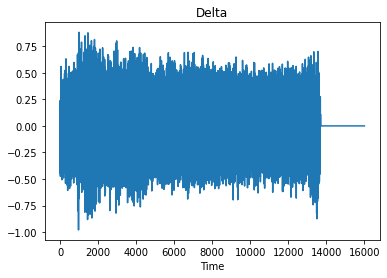

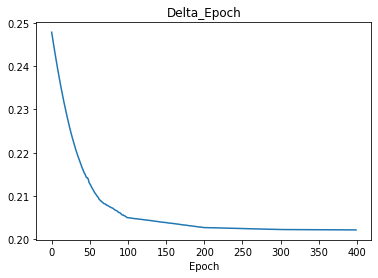

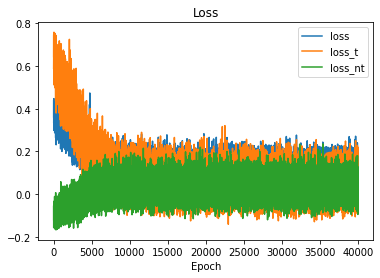

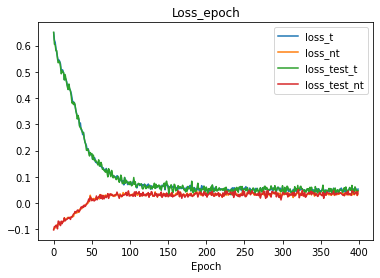

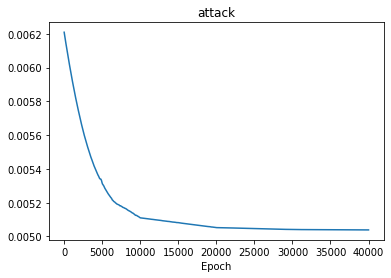

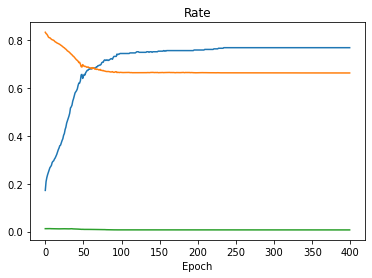

tensor([[-1.4989e-08, -7.6562e-03, -5.4888e-08,  ..., -3.1173e-09,
         -7.4913e-09,  1.1793e-08]], grad_fn=<SqueezeBackward1>)


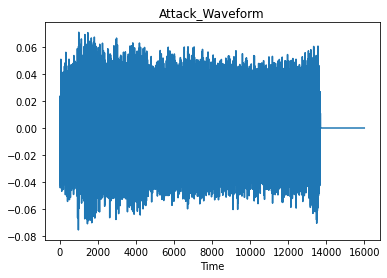

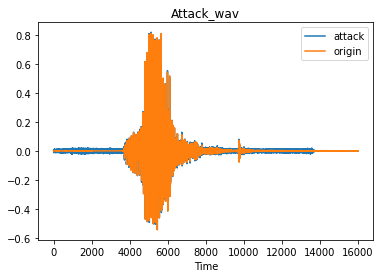


Test Epoch: 0	Attack_Accuracy: 317/412 (77%)


Test Epoch: 0	maintain_Accuracy: 7030/10593 (66%)



In [25]:

time_ = time.strftime('%d_%H_%M_%S',time.localtime(time.time()))
dir_path = os.path.join('output',time_)
os.mkdir(os.path.join('output',time_)) 

print(delta)
plt.plot(delta.squeeze().detach().to('cpu').numpy())
plt.xlabel("Time")
plt.title("Delta")
plt.savefig(os.path.join(dir_path,"Delta.png"), facecolor ="w" , edgecolor = "w") 
plt.show()
plt.close()
plt.plot(delta_sum)
plt.xlabel("Epoch")
plt.title("Delta_Epoch")
plt.savefig(os.path.join(dir_path,"Delta_Epoch.png"), facecolor ="w" , edgecolor = "w")
plt.show()
plt.close()
plt.plot(losses, label='loss')
plt.plot(losses_t, label='loss_t')
plt.plot(losses_nt, label='loss_nt')
plt.legend()
plt.xlabel("Epoch")
plt.title("Loss")
plt.savefig(os.path.join(dir_path,"Loss.png"), facecolor ="w" , edgecolor = "w" )
plt.show()
plt.close()

plt.plot(losses_t_epoch, label='loss_t')
plt.plot(losses_nt_epoch, label='loss_nt')
plt.plot(losses_test_t_epoch, label='loss_test_t')
plt.plot(losses_test_nt_epoch, label='loss_test_nt')
plt.legend()
plt.xlabel("Epoch")
plt.title("Loss_epoch")
plt.savefig(os.path.join(dir_path,"Loss_epoch.png"), facecolor ="w" , edgecolor = "w" )
plt.show()
plt.close()

plt.plot(delta_wav)
plt.xlabel("Epoch")
plt.title("attack")
plt.savefig(os.path.join(dir_path,"Attack.png"), facecolor ="w" , edgecolor = "w" )
plt.show()
plt.close()
plt.plot(attack_,label='attack')
plt.plot(maintain_,label='maintain')
plt.plot(error_,label='error')
plt.xlabel("Epoch")
plt.title("Rate")
plt.savefig(os.path.join(dir_path,"Rate.png"), facecolor ="w" , edgecolor = "w" )
plt.show()
plt.close()
threshold = 0.1

delta_ = threshold*torch.tanh(delta)
delta_ = delta_.to('cpu')
delta_ = torch.squeeze(delta_,0)

print(delta_)
plt.plot(torch.squeeze(delta_,0).detach().numpy())
plt.xlabel("Time")
plt.title("Attack_Waveform")
plt.savefig(os.path.join(dir_path,"Attack_Waveform.png"), facecolor ="w" , edgecolor = "w")
plt.show()
plt.close()
torchaudio.save(os.path.join(dir_path,"Attack.wav"), delta_ , sample_rate=16000, channels_first=True)


test_attack(model,0,threshold_epoch, delta=delta,wav_save = True)

f = open(os.path.join(dir_path,"Parameter_2.txt"), "w")  # 打开文件
print("n_epoch=",n_epoch,file=f)
print("threshold_epoch=",threshold_epoch,file=f)
print("target:origin=1:0.5",file=f)

f.close()


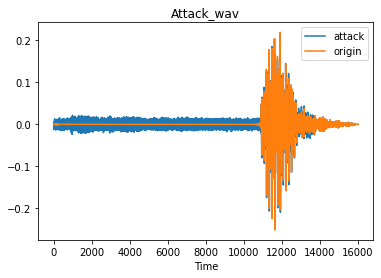


Test Epoch: 0	Attack_Accuracy: 317/412 (77%)


Test Epoch: 0	maintain_Accuracy: 7030/10593 (66%)


Test Epoch: 0	Attack_Accuracy: 28/412 (7%)


Test Epoch: 0	maintain_Accuracy: 9859/10593 (93%)



0.5

In [26]:
test_attack(model,0,threshold_epoch, delta=delta,wav_save = True)
test_attack(model,0,threshold_epoch)

In [27]:
print(len(attack_train_loader))

15


Feel free to try with one of your own recordings of one of the labels!
For example, using Colab, say “Go” while executing the cell below. This
will record one second of audio and try to classify it.




Conclusion
----------

In this tutorial, we used torchaudio to load a dataset and resample the
signal. We have then defined a neural network that we trained to
recognize a given command. There are also other data preprocessing
methods, such as finding the mel frequency cepstral coefficients (MFCC),
that can reduce the size of the dataset. This transform is also
available in torchaudio as ``torchaudio.transforms.MFCC``.


